# Case Study - 2 (RSNA Pneumonia Detection Challenge)


### By Junaid Khan (junaidkhangec@gmail.com) 

# 1. Initialization

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# max number of bounding boxes to be detected
yolo_max_boxes = 5
# IOU threshold
yolo_iou_threshold = 0.5
# Objectness threshold
yolo_score_threshold = 0.2

# 2. Utility Functions & Preprocessing

* **Metric for ChexNet calssification model**

In [2]:
# function to calculate recall
# refernce https://datascience.stackexchange.com/a/45166
# it is used as a metric for our ChexNet classification model
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

# function to calculate precision
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# function to calculate micro averaged f1_score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

* **Functions Function used inside lambda layer of YoloV3ChexNet model**

In [3]:
# Function used inside lambda layer of YoloV3ChexNet model to calculate bounding box info
def yolo_boxes(pred, anchors, classes):
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1:3]
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size[1]), tf.range(grid_size[0]))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box


# Function used inside lambda layer of YoloV3ChexNet model to perform non-maximum supression
def yolo_nms(outputs, anchors, masks, classes):
    # boxes, conf, type
    global  yolo_max_boxes, yolo_iou_threshold, yolo_score_threshold
    b, c, t = [], [], []

    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        t.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(t, axis=1)

    scores = confidence * class_probs
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class= yolo_max_boxes,
        max_total_size = yolo_max_boxes,
        iou_threshold = yolo_iou_threshold,
        score_threshold = yolo_score_threshold
    )

    return boxes, scores, classes, valid_detections

* **Functions used for image preprocessing and post-prediction processing**

In [4]:
def transform_images(x_train, size):
    x_train = tf.image.resize(x_train, (size, size))
    x_train = x_train / 255
    return x_train

def draw_outputs(img, outputs, class_names):
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

* **Function to draw ground truth bounding boxes on images**

In [5]:
def original(data):
    """
    Method to draw single patient with bounding box(es) if present 
    """
    im = cv2.imread(data['img_dir'])
    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    return im

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

* **Function to read & resize images**

In [6]:
def read_img(img_dir=None):
    img_raw = tf.image.decode_image(
            open(img_dir, 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, 416)
    return img

* **Function to transorm data into specified nested dictionary format.**

In [7]:
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'jpg': path/to/jpg/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'jpg': path/to/jpg/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'img_dir': 'data/RSNA_VOC/JPEGImages/%s.jpg' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

* **Function to predict bounding boxes given YoloV3_ChexNet model**

In [27]:
def detect(classes = 'data/RSNA_VOC/RSNA_VOC.names',
            model=None,
            size=416,
            num_classes=1,
            img=None,
            img_raw=None):
    class_names = [c.strip() for c in open(classes).readlines()]
    boxes, scores, classes, nums = model(img)
    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    return img

* **Reading Data**

In [9]:
# load image id's
ID_s = np.loadtxt('FINAL/positive_val.txt',dtype='str')
# load bounding box information 
train_data_df = pd.read_csv('data/stage_2_train_labels.csv')
parsed = parse_data(train_data_df)

In [41]:
# positive patient id from validation dataset
ID_s[:20]

array(['f1c0e838-08dd-4ec4-84a7-cedf9b87f592',
       'f1c18d3e-a250-451d-8ed6-47b85a28bfd3',
       'f1c1c792-af12-4b8a-bc67-317347a7e8d8',
       'f1c3f262-dcfd-4904-b108-38d3479e3201',
       'f1d4a238-6cfc-4875-843a-3b5044c7cdf7',
       'f1dfdb40-da03-4577-95a1-da4b170613d1',
       'f218fda3-c484-4836-867d-b7ad037bfe4e',
       'f21a2acc-e6f1-4132-b094-83c9e94a5e7d',
       'f23907b3-9638-4986-b471-b4f2873f6504',
       'f23bbee6-567d-4ef8-8b29-2ecb12a45be1',
       'f23d7784-06b4-4e44-8dcd-e1eec3e7d7cf',
       'f263d63e-1715-4bd8-af5e-fa4e824fa55b',
       'f26e5df0-bd0d-4d54-86b6-ea40ca0952a3',
       'f26ede75-cee6-4248-9219-017f327b25ca',
       'f26f795e-e989-40ce-a076-5763295ce46b',
       'f27252da-ac5d-46b2-8df9-32e09763574b',
       'f27e1121-c394-4577-80c6-762f47e916b2',
       'f29d2e7b-9a63-4614-8e61-62553edcb7fb',
       'f29da87d-abd4-4141-96d9-e48f95ca67ab',
       'f2a78be0-4397-4b01-8357-c2596406edd1'], dtype='<U36')

In [11]:
# whole parsed data
parsed

{'0004cfab-14fd-4e49-80ba-63a80b6bddd6': {'img_dir': 'data/RSNA_VOC/JPEGImages/0004cfab-14fd-4e49-80ba-63a80b6bddd6.jpg',
  'label': 0,
  'boxes': []},
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd': {'img_dir': 'data/RSNA_VOC/JPEGImages/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.jpg',
  'label': 0,
  'boxes': []},
 '00322d4d-1c29-4943-afc9-b6754be640eb': {'img_dir': 'data/RSNA_VOC/JPEGImages/00322d4d-1c29-4943-afc9-b6754be640eb.jpg',
  'label': 0,
  'boxes': []},
 '003d8fa0-6bf1-40ed-b54c-ac657f8495c5': {'img_dir': 'data/RSNA_VOC/JPEGImages/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.jpg',
  'label': 0,
  'boxes': []},
 '00436515-870c-4b36-a041-de91049b9ab4': {'img_dir': 'data/RSNA_VOC/JPEGImages/00436515-870c-4b36-a041-de91049b9ab4.jpg',
  'label': 1,
  'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]},
 '00569f44-917d-4c86-a842-81832af98c30': {'img_dir': 'data/RSNA_VOC/JPEGImages/00569f44-917d-4c86-a842-81832af98c30.jpg',
  'label': 0,
  'boxes': []},
 '006cec2e-6ce2-4549-bffa-eadf

# 3. Loading pretrained models 

In [12]:
# loading ChexNet classification model (with trained weights) 
chexnet_classifier = load_model('models and weights/chexnet_model.hdf5',custom_objects={'f1_m':f1_m})

# loading model yoloV3ChexNet model (with trained weights)
yolov3_chexnet = tf.keras.models.load_model('models and weights/yolov3_chexnet_model.hdf5')

# 4. Function_1(classify_detect)

* **It first classify an image as POSITIVE (containing opacity) or NEGATIVE (not containing opacity) using ChexNet classification model, if an image is predicted to be POSITIVE then it detects the opacity bounding boxes using YoloV3_ChexNet model.**

In [28]:
def classify_detect(classifier,detector,data,i_d):
    '''
    Parameters:
                classifier : image classification model (ChexNet)
                detector : object detection model (YoloV3_ChexNet)
                data: dictionary containing image directory  & bounding box information
                i_d: patient id (unique)
    '''
    # readin raw image
    img_raw = tf.image.decode_image(
            open(data[i_d]['img_dir'], 'rb').read(), channels=3)
    # expanding dimensions
    img = tf.expand_dims(img_raw, 0)
    # transforming image
    img = transform_images(img, 416)
    # classifier prediction
    probability = chexnet_classifier.predict(img)[0][0]
    if probability>=0.5:
        print('Opacity Detected !!')
        # detector prediction
        detected = detect(model = detector,img=img,img_raw=img_raw)
        plt.figure(figsize=(10,6))
        #plt.subplot(1,2,1)
        plt.title('YoloV3(ChexNet) Predicted')
        plt.grid(False)
        plt.imshow(detected)
        plt.show()
    else:
        print('No Opacity Detected !!')

* **Positive Case**

Opacity Detected !!


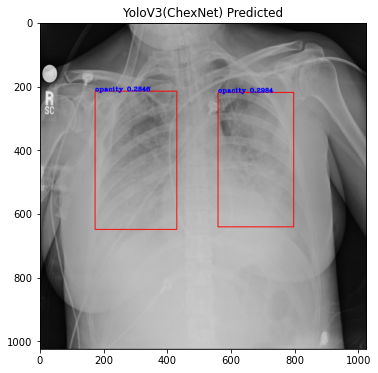

In [29]:
classify_detect(classifier=chexnet_classifier,
                detector=yolov3_chexnet,
                data=parsed,
                i_d='f21a2acc-e6f1-4132-b094-83c9e94a5e7d')

* **Negative Case**

In [30]:
classify_detect(classifier=chexnet_classifier,
                detector=yolov3_chexnet,
                data=parsed,
                i_d='0004cfab-14fd-4e49-80ba-63a80b6bddd6')

No Opacity Detected !!


# 5. Function_2 (detection)

* **It detects  & displays the opacity in images along with the ground truth bounding boxes.**

In [35]:
def detection(model,data,i_d):
    '''
    Parameters: 
                model : trained YoloV3_ChexNet object detection model
                data: data: dictionary containing image directory  & bounding box information
                i_d: patient id (unique)
    '''
    img_raw = tf.image.decode_image(
            open(data[i_d]['img_dir'], 'rb').read(), channels=3)
    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, 416)
    predicted_img = detect(model=model,img=img,img_raw=img_raw)
    original_img = original(data[i_d])
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.title('Ground Truth')
    plt.grid(False)
    plt.imshow(original_img)
    plt.subplot(1,2,2)
    plt.title('YoloV3(ChexNet) Predicted')
    plt.grid(False)
    plt.imshow(predicted_img)
    plt.show()

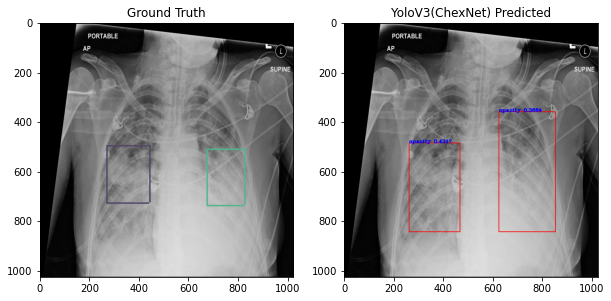

In [42]:
# detection e.g - 1
detection(model=yolov3_chexnet,data=parsed,i_d='f2a78be0-4397-4b01-8357-c2596406edd1')

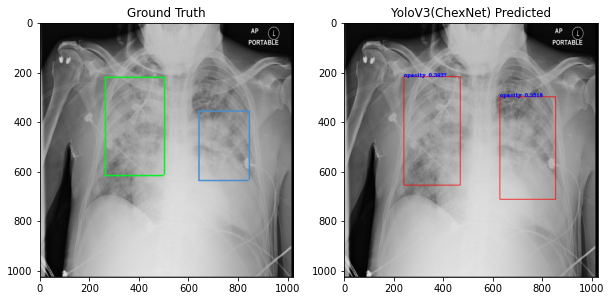

In [44]:
# detection e.g - 2
detection(model=yolov3_chexnet,data=parsed,i_d='f27e1121-c394-4577-80c6-762f47e916b2')

### Observations and further improvements:-


1. **As the dataset is quite complex and opacity bounding boxes are indistingushable from human eye we got good results with yoloV3_chexnet (if not up to the mark, as YoloV3 workes best for explicitly distingusable objects).**
2. **To further enhance our YoloV3_ChexNet model we can try image augmentation techniques as well.**